# ReAct模拟

ReAct 是目前大模型应用（Agent）最核心的设计范式。它由两个核心动作组成：思考（Reasoning） 和 行动（Acting）。

ReAct 的执行过程是一个循环链（Chain），它不是一次性把话说完，而是分步骤交互：
1. 思考（Reason）
    - 模型分析当前的任务和已有的信息。
    - 自问自答：我现在知道什么？我还需要什么？下一步该做什么？
2. 行动（Act）
    - 模型决定调用某个工具（Tool）或直接给出最终答案。
    - 例如：搜索网页、查询数据库、计算数学题。
3. 观察（Observe）
    - 执行行动后得到的结果（Observation）会被重新喂给模型。
4. 重复
    - 模型结合之前的思考和新的观察结果，进行下一步的“思考-行动”，直到任务完成。

In [3]:
import operator
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

# 定义状态类
class State(TypedDict):
    # operator.add 归约函数使该列表变为“仅追加”模式（即新值会添加到列表末尾，而不是覆盖）
    aggregate: Annotated[list, operator.add]

# 节点函数 A
def a(state: State):
    print(f'节点 A 看到 {state["aggregate"]}')
    return {"aggregate": ["A"]}

# 节点函数 B
def b(state: State):
    print(f'节点 B 看到 {state["aggregate"]}')
    return {"aggregate": ["B"]}

# 定义节点
builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)

# 定义边（路由逻辑）
def route(state: State) -> Literal["b", END]:
    # 如果 aggregate 列表的长度小于 7
    if len(state["aggregate"]) < 7:
        return "b"  # 路由到节点 b
    else:
        return END  # 否则，结束流程

# 添加边
builder.add_edge(START, "a")           # 开始 -> 节点 a
builder.add_conditional_edges("a", route) # 节点 a -> 根据 route 函数的返回值决定下一步
builder.add_edge("b", "a")             # 节点 b -> 节点 a

# 编译图
graph = builder.compile()

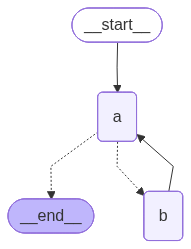

In [4]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

上面的架构类似于一个ReAct智能体，其中节点 "a" 是一个调用工具的模型，而节点 "b" 则代表工具本身。
在我们的 route 条件边逻辑中，我们指定了当状态（state）中的 "aggregate" 列表长度超过某一阈值时，流程应当结束。
调用该图时，我们可以看到节点 "a" 和 "b" 会交替执行，直到最终满足终止条件时结束。

## 扩展案例

In [1]:
import operator
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    aggregate: Annotated[list, operator.add]

def a(state: State):
    print(f'Node A sees {state["aggregate"]}')
    return {"aggregate": ["A"]}

def b(state: State):
    print(f'Node B sees {state["aggregate"]}')
    return {"aggregate": ["B"]}

def c(state: State):
    print(f'Node C sees {state["aggregate"]}')
    return {"aggregate": ["C"]}

def d(state: State):
    print(f'Node D sees {state["aggregate"]}')
    return {"aggregate": ["D"]}

# Define nodes
builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)
builder.add_node(d)

# Define edges
def route(state: State) -> Literal["b", END]:
    if len(state["aggregate"]) < 7:
        return "b"
    else:
        return END

builder.add_edge(START, "a")
builder.add_conditional_edges("a", route)
builder.add_edge("b", "c")
builder.add_edge("b", "d")
builder.add_edge(["c", "d"], "a")
graph = builder.compile()

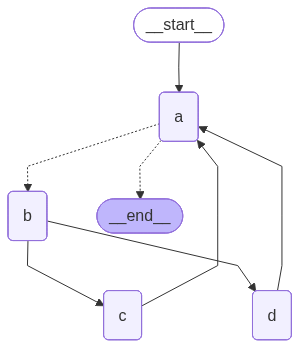

In [2]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

# RemainingSteps

LangGraph中有个状态键 `remaining_steps`，用于记录剩余的循环次数，我们可以利用这个键来判断是否应该结束运行。

In [5]:
import operator
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.managed.is_last_step import RemainingSteps

class State(TypedDict):
    aggregate: Annotated[list, operator.add]
    remaining_steps: RemainingSteps

def a(state: State):
    print(f'Node A sees {state["aggregate"]}')
    return {"aggregate": ["A"]}

def b(state: State):
    print(f'Node B sees {state["aggregate"]}')
    return {"aggregate": ["B"]}

# Define nodes
builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)

# Define edges
def route(state: State) -> Literal["b", END]:
    if state["remaining_steps"] <= 2:
        return END
    else:
        return "b"

builder.add_edge(START, "a")
builder.add_conditional_edges("a", route)
builder.add_edge("b", "a")
graph = builder.compile()

# Test it out
result = graph.invoke({"aggregate": []}, {"recursion_limit": 4})
print(result)

Node A sees []
Node B sees ['A']
Node A sees ['A', 'B']
{'aggregate': ['A', 'B', 'A']}


## 主动递归处理

In [ ]:
from typing import Annotated, Literal
from langgraph.graph import StateGraph, START, END
from langgraph.managed import RemainingSteps  # 受管理的值 - 用于跟踪距离步数限制还剩多少步

class State(TypedDict):
    messages: Annotated[list, lambda x, y: x + y]
    remaining_steps: RemainingSteps  # ← 自动注入的剩余步数追踪器

def reasoning_node(state: State) -> dict:
    # RemainingSteps 会由 LangGraph 自动填充
    remaining = state["remaining_steps"]

    # 检查剩余步数是否不足
    if remaining <= 2:
        return {"messages": ["接近步数限制，正在收尾..."]}

    # 正常处理流程
    return {"messages": ["正在思考..."]}

def route_decision(state: State) -> Literal["reasoning_node", "fallback_node"]:
    """根据剩余步数进行路由"""
    if state["remaining_steps"] <= 2:
        return "fallback_node"
    return "reasoning_node"

def fallback_node(state: State) -> dict:
    """处理接近递归限制的情况"""
    return {"messages": ["已达到复杂度限制，正在提供最佳答案"]}

# 构建图
builder = StateGraph(State)
builder.add_node("reasoning_node", reasoning_node)
builder.add_node("fallback_node", fallback_node)
builder.add_edge(START, "reasoning_node")
builder.add_conditional_edges("reasoning_node", route_decision)
builder.add_edge("fallback_node", END)

graph = builder.compile()

# RemainingSteps 可以配合任意 recursion_limit 使用
result = graph.invoke({"messages": []}, {"recursion_limit": 10})

## 被动递归处理

In [ ]:
# 被动式方法（降级/兜底）—— 在外部捕获错误
try:
    result = graph.invoke({"messages": []}, {"recursion_limit": 10})
except GraphRecursionError as e:
    # 在图执行失败后，于外部进行处理
    result = {"messages": ["降级处理：递归次数超过限制"]}